# 1. Import Data

Import and sort the data by date

In [196]:
import pandas as pd
import os
import re
from datetime import timedelta

# Define a custom parser for the 'hour_number' column to handle the specific format
def parse_hour_number(hour_str, date_str):
    # Check if the hour part is '24', and adjust date and time accordingly
    if hour_str == '24':
        hour_str = '0'  # Reset hour to '00'
        # Convert date_part to a datetime object to add a day
        date_obj = pd.to_datetime(date_str, format="%Y%m%d")
        # Add one day to the date
        date_obj += timedelta(days=1)
        # Convert back to string with the new date
        date_str = date_obj.strftime("%Y%m%d")
    # Construct a datetime string, now with hour always in valid range
    datetime_str = f"{date_str} {hour_str.zfill(2)}:00:00"
    # Convert to a datetime object
    return pd.to_datetime(datetime_str, format="%Y%m%d %H:%M:%S")

# Define the directory where your CSV files are stored
directory_path = 'downloaded_csvs/'

# Compile a regular expression pattern to match the file names
pattern = re.compile(r'PUB_DispUnconsHOEP_\d{8}\.csv')

# Initialize an empty DataFrame to store all the data
df = pd.DataFrame()

# Loop through the files in the directory
for file_name in os.listdir(directory_path):
    # Check if the file name matches the pattern
    if pattern.match(file_name):
        # Construct the full file path
        file_path = os.path.join(directory_path, file_name)
        # Parse the date from the file name
        date_str = file_name.split('_')[-1].split('.')[0]
        # Read the CSV file
        df_temp = pd.read_csv(file_path, header=None)
        # Rename the columns
        df_temp.columns = ['Hour', 'price', 'Type']
        # Convert the 'Hour' column to string and then to datetime using the custom parser
        df_temp['DateTime'] = df_temp['Hour'].astype(str).apply(parse_hour_number, args=(date_str,))
        # Drop the 'Hour' and 'Type' columns
        df_temp = df_temp.drop(['Hour', 'Type'], axis=1)
        # Append the data to the combined DataFrame
        df = pd.concat([df, df_temp], ignore_index=True)
        # Sort the DataFrame by the 'DateTime' column
        
df = df.sort_values(by='DateTime')
df = df.set_index('DateTime')

# Remove the last incomplete day, so that the data ends at 23:00:00
df = df[:'2024-03-08 23:00:00']

print(df)
# Save the combined DataFrame to a new CSV file if needed
# combined_df.to_csv('combined_energy_prices.csv', index=False)

                     price
DateTime                  
2023-12-09 01:00:00  17.79
2023-12-09 02:00:00  14.34
2023-12-09 03:00:00  22.23
2023-12-09 04:00:00  17.85
2023-12-09 05:00:00  26.74
...                    ...
2024-03-08 19:00:00  31.38
2024-03-08 20:00:00  26.47
2024-03-08 21:00:00  24.19
2024-03-08 22:00:00  23.40
2024-03-08 23:00:00  23.10

[2183 rows x 1 columns]


# 2. Exploratory Data Analysis (EDA):
## 2.1 Average Trends
Look at the overall plot, monthly, weekly, and daily plots to get a sense of noises and trends

/var/folders/jj/ff41wwp55fb8g5_7xq6nlfnr0000gn/T/ipykernel_25185/1030763740.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees
/var/folders/jj/ff41wwp55fb8g5_7xq6nlfnr0000gn/T/ipykernel_25185/1030763740.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees
/var/folders/jj/ff41wwp55fb8g5_7xq6nlfnr0000gn/T/ipykernel_25185/1030763740.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees


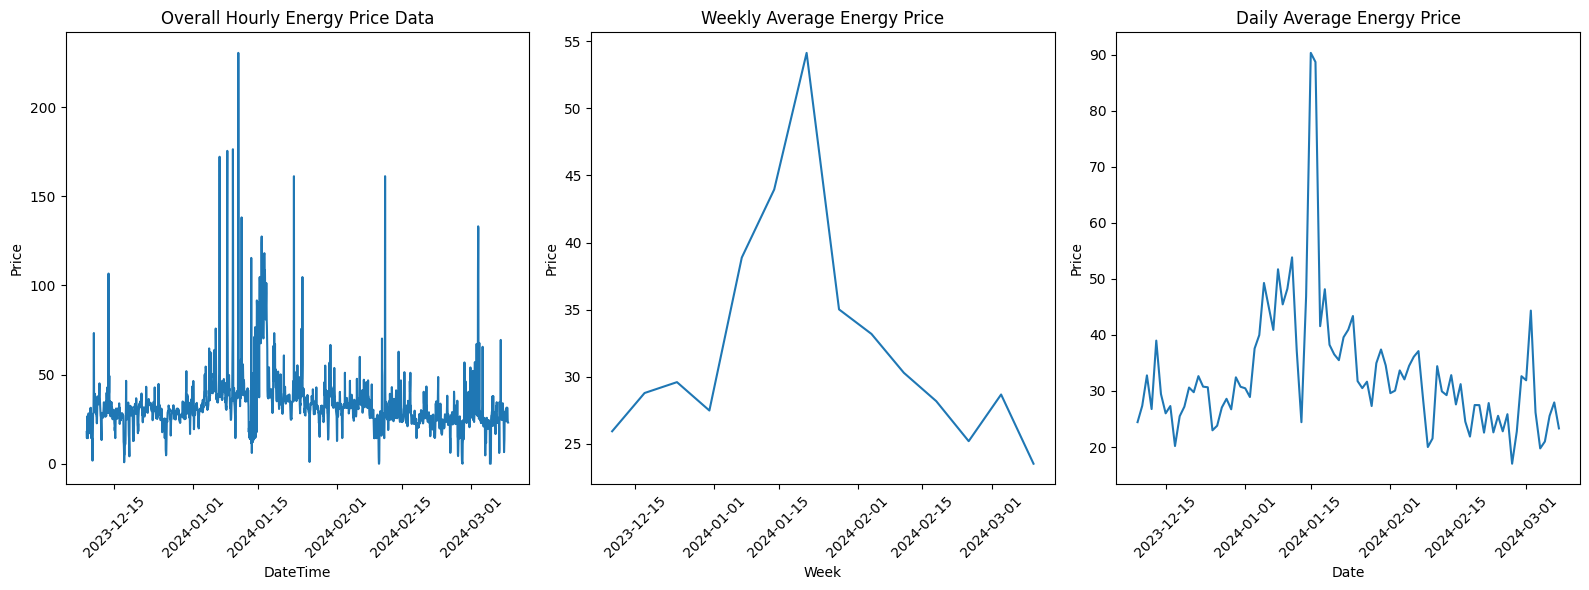

In [197]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axs = plt.subplots(1, 3, figsize=(16, 6))  # Specify ncols=3

# Plot the overall data
axs[0].plot(df['price'])
axs[0].set_xlabel('DateTime')
axs[0].set_ylabel('Price')
axs[0].set_title('Overall Hourly Energy Price Data')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees

# Resample the data to weekly frequency and plot
weekly_data = df.resample('W').mean()
axs[1].plot(weekly_data['price'])
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Price')
axs[1].set_title('Weekly Average Energy Price')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees

# Resample the data to daily frequency and plot
daily_data = df.resample('D').mean()
axs[2].plot(daily_data['price'])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].set_title('Daily Average Energy Price')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)  # Rotate x-axis labels by 45 degrees

plt.tight_layout()
plt.show()

Quite a bit of fluctuations with no clear trend

## Weekly Detailed View
Plot data over the week to see if there is any pattern

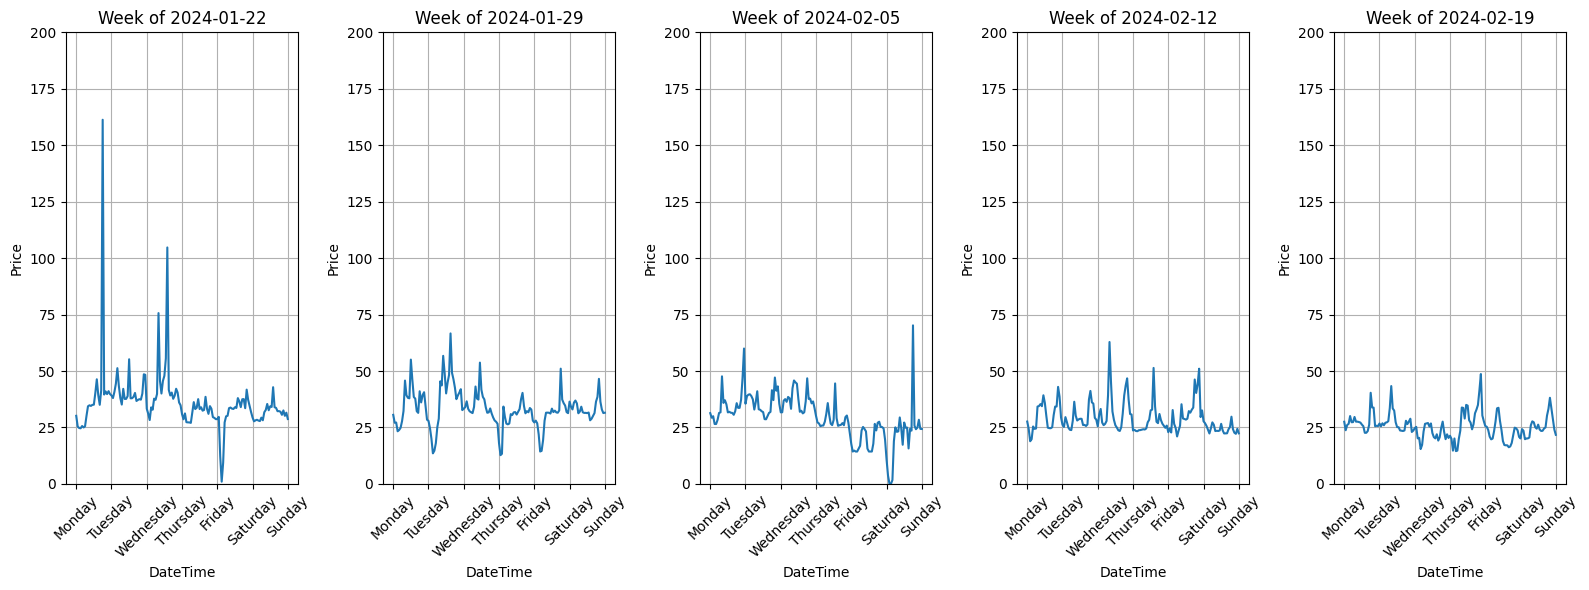

In [198]:
# Specify the starting dates for each week
start_dates = ['2024-01-22', '2024-01-29', '2024-02-05', '2024-02-12', '2024-02-19']

# Create a figure with horizontal subplots
fig, axs = plt.subplots(1, 5, figsize=(16, 6))

# Iterate over each starting date and subplot index
for i, start_date in enumerate(start_dates):
    # Calculate the end date for the week (7 days later)
    end_date = pd.to_datetime(start_date) + pd.Timedelta(days=6)
    
    # Filter the data for the specific week
    week_data = df.loc[start_date:end_date]
    
    # Plot the data on the corresponding subplot
    axs[i].plot(week_data.index, week_data['price'])
    axs[i].set_title(f'Week of {start_date}')
    axs[i].set_xlabel('DateTime')
    axs[i].set_ylabel('Price')
    axs[i].grid(True)
    axs[i].set_ylim([0, 200])
    
    # Set the x-axis ticks to display all days of the week
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%A'))  # Display the day of the week
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-labels by 45 degrees

# Adjust the spacing and layout
fig.tight_layout()    

# Display the plot
plt.show()


Fluctuations throughout the day

## Day View
Plot data over the day to see if there is any pattern

[datetime.date(2024, 1, 29) datetime.date(2024, 2, 17)
 datetime.date(2024, 2, 1)]


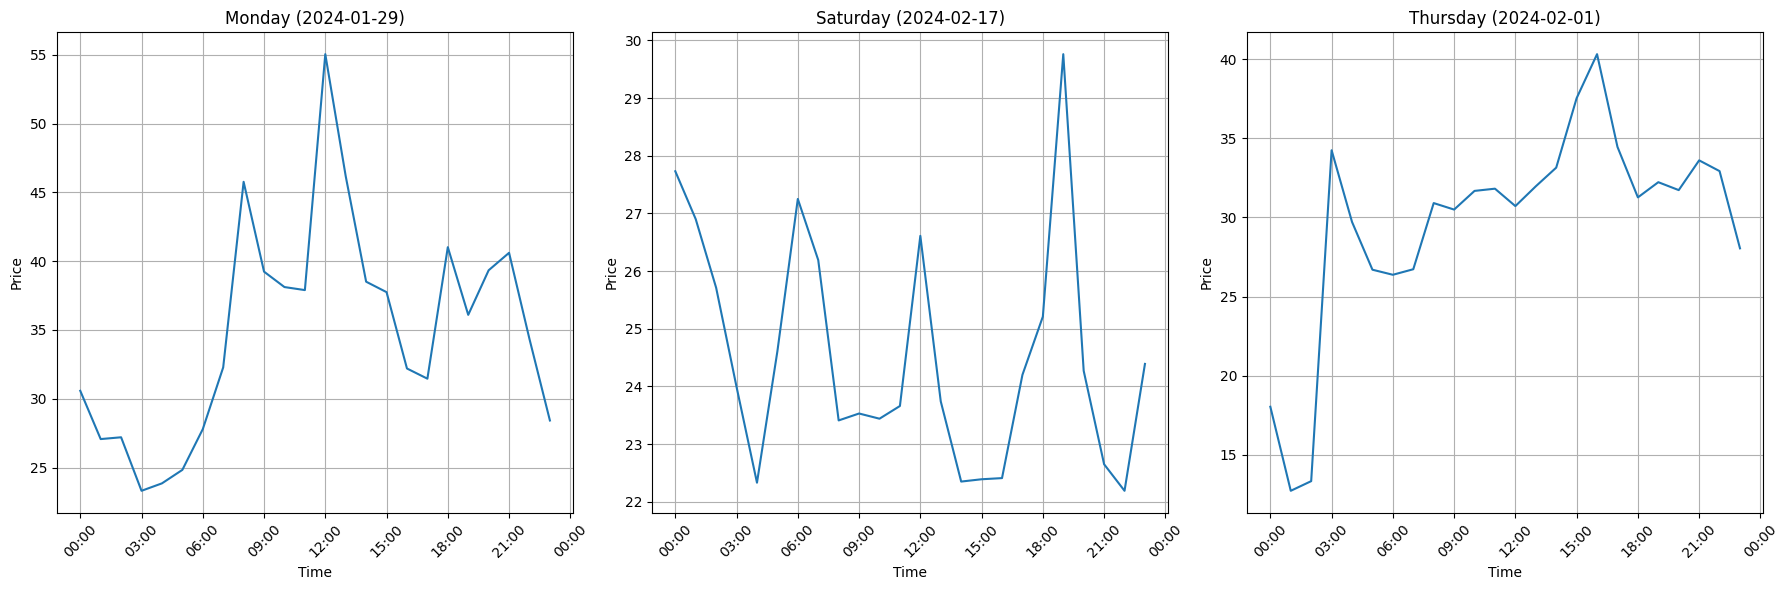

In [199]:
import random

# Plot hourly data for a few random days
# Select a few random days from the dataframe
random_days = df.sample(n=3).index.date
print(random_days)
# Create a figure with subplots for each day
fig, axs = plt.subplots(1,len(random_days), figsize=(6 * len(random_days), 6))

# Iterate over each random day and subplot index
for i, day in enumerate(random_days):
    # Filter the data for the specific day
    day_data = df.loc[df.index.date == day]
    
    # Get the day of the week
    day_of_week = day.strftime('%A')
    
    # Plot the data on the corresponding subplot
    axs[i].plot(day_data.index, day_data['price'])
    axs[i].set_title(f'{day_of_week} ({day})')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Price')
    axs[i].grid(True)
    
    # axs[i].set_ylim([0, 200])
    
    # Set the x-axis ticks to display hours
    axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Display hours and minutes
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-labels by 45 degrees

# Adjust the spacing and layout
fig.tight_layout()    

# Display the plot
plt.show()


### 3 Random Wednesdays
Focus on just one day of the week to try to isolate a pattern

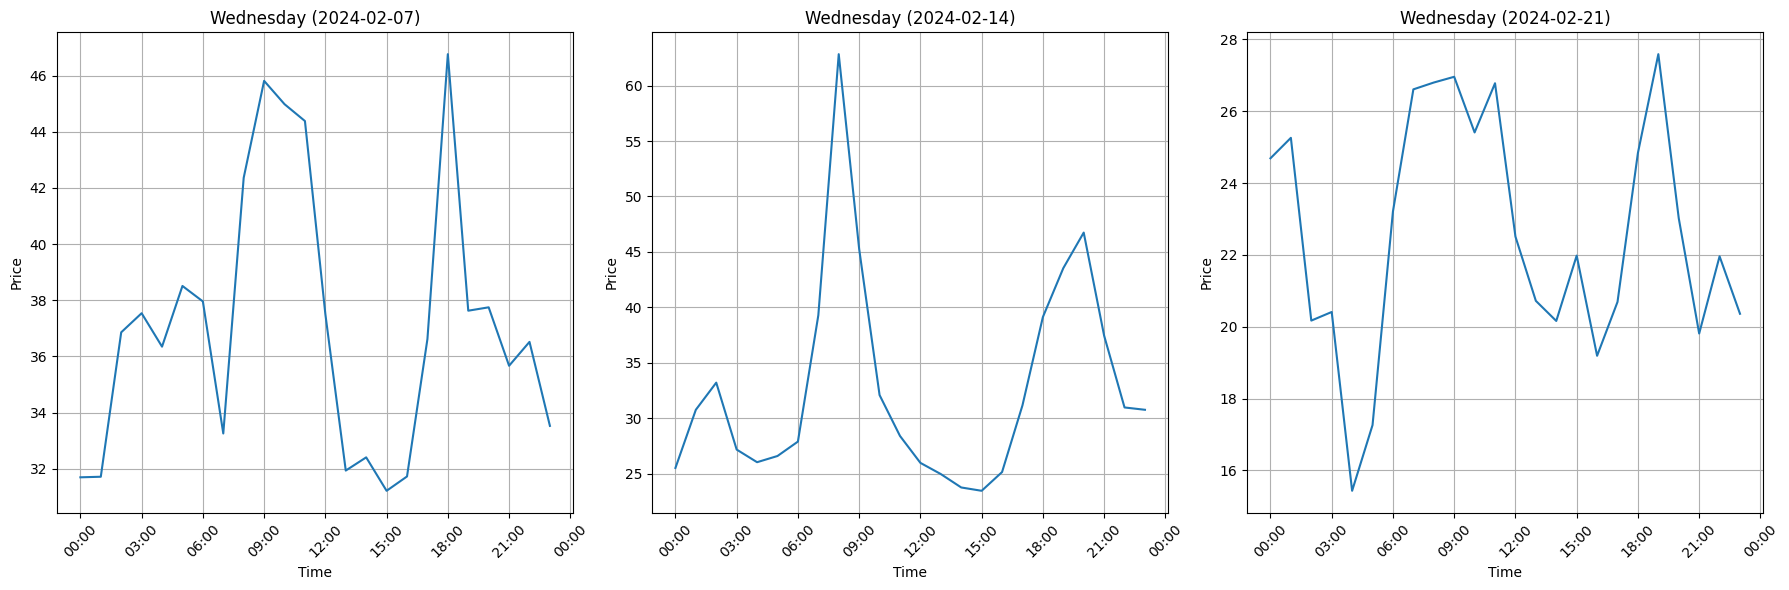

In [200]:
# Select 3 wednesdays from the dataframe (2/8, 2/15, 2/22) and convert them to datetime
random_days = pd.to_datetime(['2024-02-07', '2024-02-14', '2024-02-21']).date

# Create a figure with subplots for each day
fig, axs = plt.subplots(1,len(random_days), figsize=(6 * len(random_days), 6))

# Iterate over each random day and subplot index
for i, day in enumerate(random_days):
    # Filter the data for the specific day
    day_data = df.loc[df.index.date == day]
    
    # Get the day of the week
    day_of_week = day.strftime('%A')
    
    # Plot the data on the corresponding subplot
    axs[i].plot(day_data.index, day_data['price'])
    axs[i].set_title(f'{day_of_week} ({day})')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Price')
    axs[i].grid(True)
    
    # axs[i].set_ylim([0, 200])
    
    # Set the x-axis ticks to display hours
    axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Display hours and minutes
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-labels by 45 degrees

# Adjust the spacing and layout
fig.tight_layout()    

# Display the plot
plt.show()


Peaks around 9 AM and 7 PM, valleys around midnight and 3 PM

# 3. Augmented Dickey-Fuller (ADF) Test
Hypothesis: Data is stationary if p < 0.05



In [201]:
# Import the adfuller function from statsmodels
from statsmodels.tsa.stattools import adfuller

# Apply the Augmented Dickey-Fuller test on the 'price' column
adf_result = adfuller(df['price'])

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpretation based on p-value
if adf_result[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")

ADF Statistic: -4.049226106099858
p-value: 0.0011735875946264104
Critical Values:
   1%: -3.4333810594081227
   5%: -2.862879013318124
   10%: -2.5674828242884087
The series is likely stationary.


# 4. Fitting with ARIMA (Autoregressive integrated moving average)

## 4.1 Model Identification
Before fitting an ARIMA model, identify the appropriate order of the AR (autoregressive) and MA (moving average) components. This is typically done by examining the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

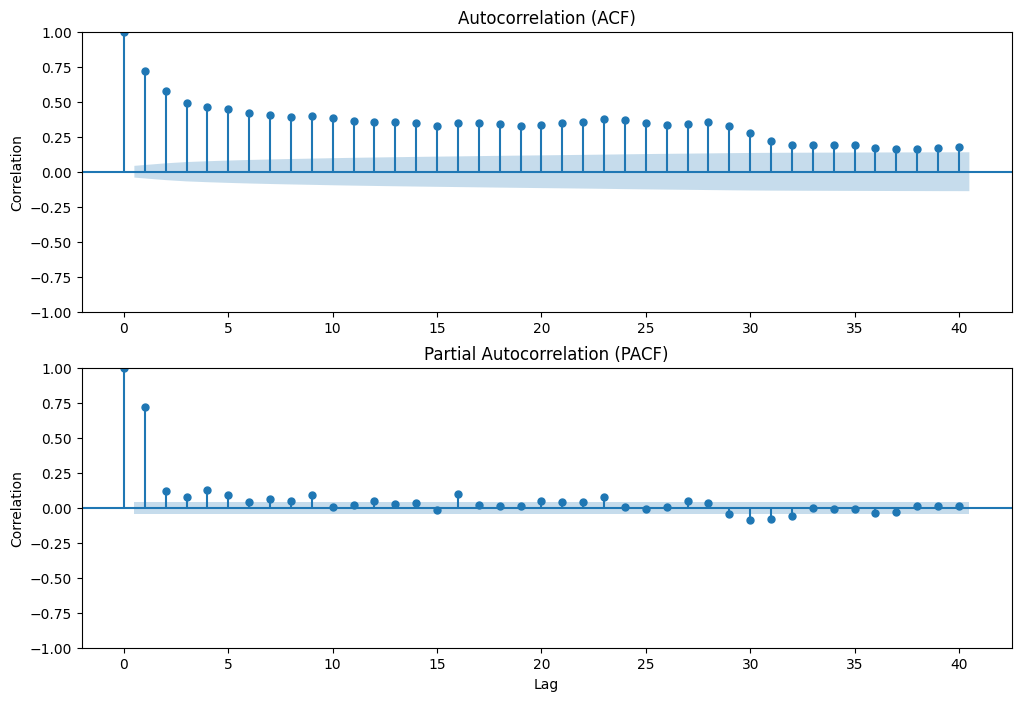

In [202]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF on the first subplot
plot_acf(df['price'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation (ACF)')
ax1.set_ylabel('Correlation')

# Plot the PACF on the second subplot
plot_pacf(df['price'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

plt.show()


## Interpretation:
#### From the ACF plot:
<ol>
  <li>Strong positive correlation at lag 1: Significant relationship between consecutive (hourly) observations.</li>
  <li>Autocorrelation remains significant for many lags, implying a persistent long-term memory in the series.</li>
</ol>

#### From the PACF plot:
<ol>
  <li>Significant positive spike at lag 1: Strong direct relationship between an observation and the next.</li>
  <li>The partial autocorrelations beyond lag 1 are relatively small and mostly within the confidence interval, suggesting that the series can be adequately modeled with a low-order autoregressive (AR) component (AR(1)).</li>
</ol>


## 4.2 Non-Seasonal ARIMA Model
Try with non-seasonal ARIMA model first. Auto-fitted with auto-arima

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1746
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6799.558
Date:                Wed, 13 Mar 2024   AIC                          13605.115
Time:                        17:06:20   BIC                          13621.509
Sample:                    12-09-2023   HQIC                         13611.176
                         - 02-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4850      0.012     41.527      0.000       0.462       0.508
ma.L1         -0.9169      0.010    -91.619      0.000      -0.936      -0.897
sigma2       141.8506      0.934    151.830      0.0

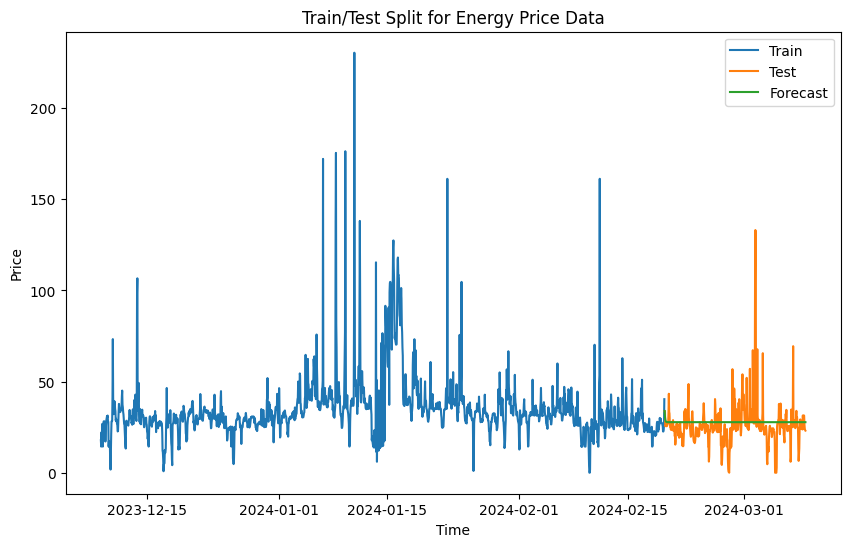

In [217]:
# Import the auto_arima function from the pmdarima package
from pmdarima import auto_arima

# Splitting the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df['price'][:train_size], df['price'][train_size:]

# Running auto_arima on the training set to find the best ARIMA model
best_model = auto_arima(train, stepwise=True, seasonal=False, trace=False,
                        max_p=10, max_d=10, max_q=10,
                        error_action='ignore', suppress_warnings=True)

print(best_model.summary())

# Forecasting on the test set
forecast = best_model.predict(n_periods=len(test))

# Comparing predicted values to the actual test data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('Train/Test Split for Energy Price Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Best model found was ARIMA(p=1, d=1, q=1). \
Bad results with high AIC (Akaike Information Criterion). This time series exhibits seasonality. Therefore, we will try a seasonal ARIMA model.

## 4.3 Seasonal ARIMA Model
Try with seasonal ARIMA model. Auto-fitted with auto-arima.

In [ ]:
best_model = auto_arima(train, stepwise=True, seasonal=True, trace=False,
                        m=7,
                        max_p=10, max_d=10, max_q=10, max_P=10, max_D=10, max_Q=10,
                        error_action='ignore', suppress_warnings=True)

print(best_model.summary())

# Forecasting on the test set
forecast = best_model.predict(n_periods=len(test))

# Comparing predicted values to the actual test data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('Train/Test Split for Energy Price Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 5. Fitting with Prophet

## 1. Fitting to the last few days

17:26:23 - cmdstanpy - INFO - Chain [1] start processing
17:26:23 - cmdstanpy - INFO - Chain [1] done processing
/Users/henrywu/Desktop/MSCI Assignments/Project/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/henrywu/Desktop/MSCI Assignments/Project/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/henrywu/Desktop/MSCI Assignments/Project/.venv/lib/python3.12/site-packages/prophet

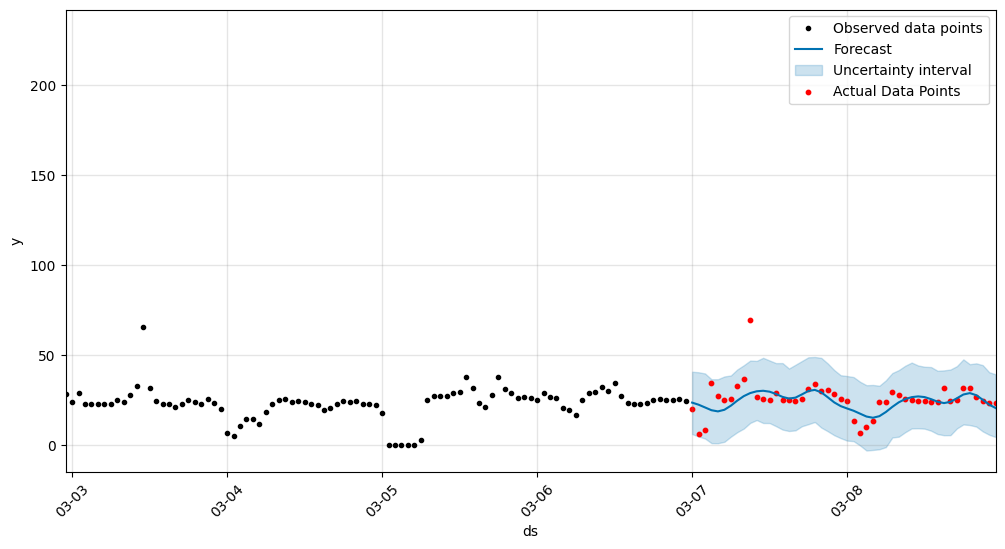

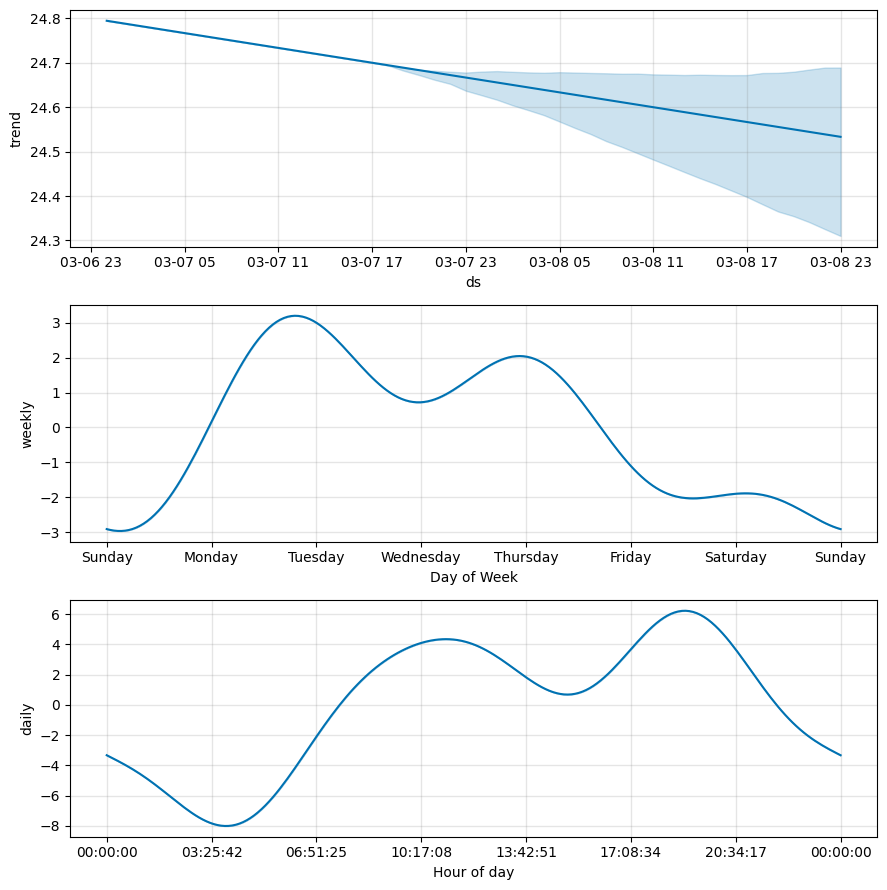

In [221]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Set the number of days to predict
days_to_predict = 1

# Make a copy of the input DataFrame
dfp = df.copy()

# Reset the index to make 'DateTime' a regular column
dfp.reset_index(inplace=True)

# Rename the columns to 'ds' and 'y' for Prophet
dfp.rename(columns={'DateTime': 'ds', 'price': 'y'}, inplace=True)

# Get the last date that starts at midnight
last_date = dfp['ds'].max().floor('D')

# Roll back the training data by the specified number of days
train_end_date = last_date - pd.Timedelta(days=days_to_predict)

# Split the data into training and testing sets
train_data = dfp[dfp['ds'] < train_end_date]
test_data = dfp[dfp['ds'] >= train_end_date]

# Fit the Prophet model on the training data
model = Prophet()
model.fit(train_data)

# Make predictions on the future dates
forecast = model.predict(test_data)

# Plot the forecast
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)

# Plot the actual test data points as small dots
plt.scatter(test_data['ds'], test_data['y'], s=10, c='r', label='Actual Data Points')
plt.legend()

# Zoom in on the last few days
last_few_days = forecast['ds'].max() - pd.Timedelta(days=days_to_predict + 5)
ax.set_xlim(left=last_few_days, right=forecast['ds'].max())

# Rotate and format the x-axis ticks for better readability
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
plt.xticks(rotation=45)

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

## 2. Overall fitting, Predict last month.

16:37:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:38 - cmdstanpy - INFO - Chain [1] done processing
/Users/henrywu/Desktop/MSCI Assignments/Project/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/henrywu/Desktop/MSCI Assignments/Project/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


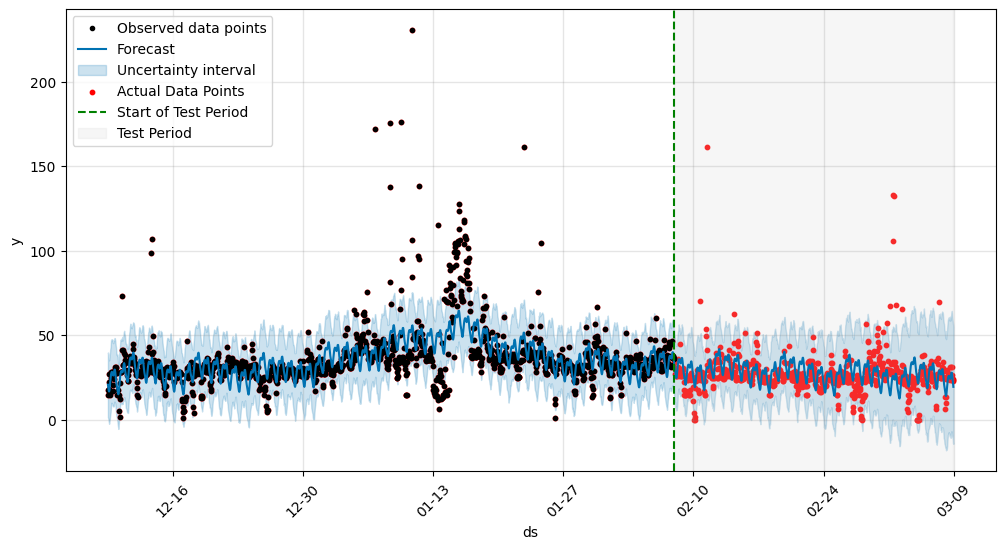

In [213]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Make a copy of the input DataFrame
dfp = df.copy()

# Reset the index to make 'DateTime' a regular column
dfp.reset_index(inplace=True)

# Rename the columns to 'ds' and 'y' for Prophet
dfp.rename(columns={'DateTime': 'ds', 'price': 'y'}, inplace=True)

# Get the last date in the dataset
last_date = dfp['ds'].max()

# Set the test data period to be the last month
test_start_date = last_date - pd.Timedelta(days=30)

# Split the data into training and testing sets
train_data = dfp[dfp['ds'] < test_start_date]
test_data = dfp[dfp['ds'] >= test_start_date]

# Fit the Prophet model on the training data
model = Prophet()
model.fit(train_data)

# Make predictions for the entire dataset (in-sample and future)
forecast = model.predict(dfp)

# Plot the forecast
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)

# Plot the actual data points as small dots
plt.scatter(dfp['ds'], dfp['y'], s=10, c='r', label='Actual Data Points')

# Highlight the test data period
plt.axvline(x=test_start_date, color='g', linestyle='--', label='Start of Test Period')
plt.axvspan(test_start_date, last_date, alpha=0.2, color='lightgray', label='Test Period')

plt.legend()

# Rotate and format the x-axis ticks for better readability
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
plt.xticks(rotation=45)

plt.show()